# Candidate Model Builds

In this Python Notebook, several candidate models are built to see which algorithm appears to be the most accurate at predicting the strength of concrete. The averages for Mean Absolute Error and Root Mean Squared Error obtained from cross validation are used to determine the overall performance of the models. 

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import ensemble, linear_model, metrics, model_selection, preprocessing
import xgboost as xgb

def shortenModelName(mdl):
    if mdl == 'sklearn.linear_model._base.LinearRegression':
        return 'Linear Regression'
    elif mdl == 'sklearn.ensemble._forest.RandomForestRegressor':
        return 'Random Forest'
    elif mdl == 'sklearn.linear_model._stochastic_gradient.SGDRegressor':
        return 'SGD'
    elif mdl == 'sklearn.linear_model._coordinate_descent.ElasticNet':
        return 'Elastic Net'
    elif mdl == 'xgboost.sklearn.XGBRegressor':
        return 'XGBoost'
    elif mdl == 'lightgbm.sklearn.LGBMRegressor':
        return 'LightGBM'
    else:
        return mdl

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv


In [2]:
data_input_path = '/kaggle/input/playground-series-s3e9/'
train_df = pd.read_csv(data_input_path + 'train.csv')
test_df = pd.read_csv(data_input_path + 'test.csv')

train_df.head()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


### Create X and y Matrices

Separate the train_df into X and y to fit the models while also using cross validation. 

In [3]:
non_mdl_labels = [
    'id',
    'Strength' 
    #'z_cementcomponent', 'z_blastfurnaceslag', 'z_flyashcomponent', 
    #'z_watercomponent', 'z_superplasticizercomponent', 'z_coarseaggregatecomponent', 
    #'z_fineaggregatecomponent', 'z_ageindays', 'z_strength'
]

X = train_df.drop(labels = non_mdl_labels, axis = 1).values
y = train_df['Strength'].values

# x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.33, random_state = 42)

# scaler.fit(x_train)
# scaled_x_train = scaler.transform(x_train)
# scaled_x_test = scaler.transform(x_test)

### Fitting and Cross Validation

* Using 3 folds perform cross validation
* Fit each type of model algorithm to the data
* Scale features using preprocessing.StandardScaler from sklearn

In [4]:
sk_lin_reg = linear_model.LinearRegression()
rf_regr = ensemble.RandomForestRegressor()
sgd_reg = linear_model.SGDRegressor()
enet_reg = linear_model.ElasticNet()
xgb_reg = xgb.XGBRegressor()
lgb_reg = lgb.LGBMRegressor()

model_list = [sk_lin_reg, rf_regr, sgd_reg, enet_reg, xgb_reg, lgb_reg]

# evaluation metrics
# used to build eval df
models = []
avg_mae = []
avg_rmse = []

num_folds = 3
k_fold = model_selection.KFold(num_folds)

# standard scaler
scaler = preprocessing.StandardScaler()

# for each model candidate, perform kfolds cross validation 
for mdl in model_list:
    model_obj_name = str(type(mdl)).replace("'", '').replace(' ', '').replace('class', '').replace('<', '').replace('>', '')
    models.append(model_obj_name)
    mae_scores = []
    rmse_scores = []
    for train_index, test_index in k_fold.split(X):
        # create train and test
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # scale features
        scaler.fit(x_train)
        scaled_x_train = scaler.transform(x_train)
        scaled_x_test = scaler.transform(x_test)
        # fit 
        mdl.fit(scaled_x_train, y_train)
        y_test_pred = mdl.predict(scaled_x_test)
        mae_scores.append(metrics.mean_absolute_error(y_true = y_test, y_pred = y_test_pred))
        rmse_scores.append(np.sqrt(metrics.mean_squared_error(y_true = y_test, y_pred = y_test_pred)))
    avg_mae.append(np.mean(mae_scores))
    avg_rmse.append(np.mean(rmse_scores))

In [5]:
mae_eval_df = pd.DataFrame.from_dict({'Model Algorithm': models, 'Eval Metric Value': avg_mae})
mae_eval_df['Eval Metric'] = 'MAE'
mae_eval_df['Model'] = mae_eval_df['Model Algorithm'].apply(lambda x: shortenModelName(x))


rmse_eval_df = pd.DataFrame.from_dict({'Model Algorithm': models, 'Eval Metric Value': avg_rmse})
rmse_eval_df['Eval Metric'] = 'RMSE'
rmse_eval_df['Model'] = rmse_eval_df['Model Algorithm'].apply(lambda x: shortenModelName(x))

eval_df = pd.concat([mae_eval_df, rmse_eval_df])

<Axes: xlabel='Model', ylabel='Eval Metric Value'>

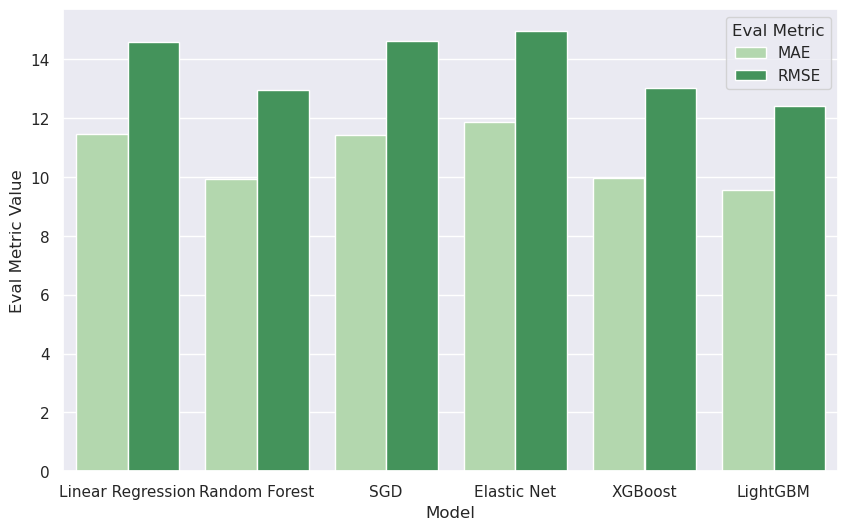

In [6]:
sns.set(rc={'figure.figsize':(10,6)})

sns.barplot(
    data = eval_df,
    x = 'Model',
    y = 'Eval Metric Value',
    hue = 'Eval Metric',
    palette = 'Greens'
)

In [7]:
eval_df

,Model Algorithm,Eval Metric Value,Eval Metric,Model
0,sklearn.linear_model._base.LinearRegression,11.439625,MAE,Linear Regression
1,sklearn.ensemble._forest.RandomForestRegressor,9.935432,MAE,Random Forest
2,sklearn.linear_model._stochastic_gradient.SGDR...,11.438697,MAE,SGD
3,sklearn.linear_model._coordinate_descent.Elast...,11.878349,MAE,Elastic Net
4,xgboost.sklearn.XGBRegressor,9.956921,MAE,XGBoost
5,lightgbm.sklearn.LGBMRegressor,9.547388,MAE,LightGBM
0,sklearn.linear_model._base.LinearRegression,14.594945,RMSE,Linear Regression
1,sklearn.ensemble._forest.RandomForestRegressor,12.935760,RMSE,Random Forest
2,sklearn.linear_model._stochastic_gradient.SGDR...,14.612551,RMSE,SGD
3,sklearn.linear_model._coordinate_descent.Elast...,14.946981,RMSE,Elastic Net


### Results Summary

LightGBM appears to have the best accuracy in terms of both MAE and RMSE. Random Forest and XGBoost were second and third with close performance. Multiple Linear Regression is not close to the three previous algorithms mentioned suggesting that a non-parametric model is likely to be better for this specific use case. 